In [1]:
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

from rsq import AgglomerativeEnsemble

import matplotlib.pyplot as plt

def stratified_sample(y, p=0.67, replace=False):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    
    inds = [np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)]
    
    return np.concatenate(inds)

In [2]:
def few_shot_gaussians(n, d, n_classes=2, type2_var=0.5, var=1, n_labels_per_class=1, n_test=100, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
                
    means = np.random.multivariate_normal(np.zeros(d), type2_var * np.eye(d), size=int(n_classes))
            
    data = np.concatenate([np.random.multivariate_normal(mean, var*np.eye(d), size=n) for mean in means])
    latent_labels = np.concatenate([i*np.ones(n) for i in range(n_classes)])
    
    data_test = np.concatenate([np.random.multivariate_normal(mean, var*np.eye(d), size=n_test) for mean in means])
    y_test = np.concatenate([i*np.ones(n_test) for i in range(n_classes)])
    
    shuf = np.random.choice(n_classes*n, n_classes*n, replace=False)
    data, latent_labels = data[shuf], latent_labels[shuf]
    
    known_labels = -1 * np.ones(n_classes*n)
    labeled_inds = [np.where(latent_labels == i)[0][:n_labels_per_class] for i in range(n_classes)]
    
    for i, inds in enumerate(labeled_inds):
        known_labels[inds] = i
                
    return data, known_labels, latent_labels, data_test, y_test

In [3]:
def gem(x, p=1):
    """ generalized mean pooling -- interpolation between mean and max """
    nobs, ndim = x.shape
    
    y = np.zeros(ndim)
    for r in range(nobs):
        for c in range(ndim):
            y[c] += x[r,c] ** p
    
    y /= nobs
    
    for c in range(ndim):
        y[c] = y[c] ** (1 / p)
    
    return y



class AgglomerativeClassifier:
    def __init__(self, n_clusters=2, affinity='cosine', linkage='average',
                n_neighbors=1,
                 max_tree_distance=None,
                 soft_max_multiplier=10,
                 gem_p=1,
                classes=None):
        
        self.n_clusters = n_clusters
        self.affinity = affinity
        self.linkage = linkage
        
        self.n_neighbors = n_neighbors
                
        self.classes_ = classes
        
        self.max_tree_distance=max_tree_distance
        self.soft_max_multiplier=soft_max_multiplier
        
        self.gem_p = gem_p
        
        
    def fit(self, X, y):
        self.n, d = X.shape

        self.labeled_inds = np.where(y != -1)[0]
                
        if self.classes_ is None:
            self.classes_ = np.unique(y[self.labeled_inds])
            
        if -1 in self.classes_:
            self.classes_ = self.classes_[1:]
                        
        self.model = AgglomerativeClustering(n_clusters=self.n_clusters, 
            affinity=self.affinity, 
            linkage=self.linkage, 
            compute_full_tree=True
            )
        self.model.fit(X)
                    
        self.nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.affinity)
        self.nn.fit(X)
        
        labeled_inds_by_class = [np.where(y[self.labeled_inds] == c)[0] for c in self.classes_]
        decision_paths, counts = get_decision_paths(self.n, self.model.children_)
        
        self._get_tree_distances(decision_paths, counts)        
        self._get_similarities_to_classes(labeled_inds_by_class)
        
                                    
    def _get_tree_distances(self, decision_paths, counts):
        self.tree_distances = get_tree_distances(self.n, decision_paths, self.labeled_inds, counts, self.max_tree_distance)
        self.tree_distances = np.log(self.tree_distances) + 1
        self.tree_distances = 1 / self.tree_distances
        self.tree_distances = softmax(self.soft_max_multiplier * self.tree_distances, axis=0)
        
        
    def _get_similarities_to_classes(self, labeled_inds_by_class):
        self.similarities_to_classes = np.zeros((self.n, len(self.classes_)))
        
        for i, ibc in enumerate(labeled_inds_by_class):
            self.similarities_to_classes[:, i] = gem(self.tree_distances[:, ibc].T, p=self.gem_p)
                                              
        self.similarities_to_classes = softmax(self.similarities_to_classes, axis=1)
        
        
    def predict_proba(self, X):
        _, neighbor_inds = self.nn.kneighbors(X)
        scores = np.mean(self.similarities_to_classes[neighbor_inds], axis=1)
        return softmax(scores, axis=1)
    
    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]



In [4]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_moons

def exp(n, n_labeled, noise=0.1):
    accuracies = np.zeros(3)
    X, y = make_moons(n, noise=0.1)
    
    at_least_1_per = False
    while not at_least_1_per:
        inds = np.random.choice(len(y), n_labeled, replace=False)
        if len(np.where(y[inds] == 1)[0]) > 0 and len(np.where(y[inds] == 1)[0]) < n_labeled:
            at_least_1_per=True

    y_ = -1 * np.ones(n)
    y_[inds] = y[inds]

    n_neighbors = int(np.math.ceil(np.math.log(n_labeled)))
#     clf=AgglomerativeClassifier(affinity='euclidean', linkage='single', n_neighbors=n_neighbors, gem_p=16)
    clf=AgglomerativeEnsemble(n_estimators=2, affinity='euclidean', linkage='single', n_neighbors=n_neighbors, gem_p=16)

    clf.fit(X, y_)
    y_hat=clf.predict(X)
    accuracies[0] = (y == y_hat).mean()
    
    
    clf=SVC()
    clf.fit(X[inds], y[inds])
    y_hat=clf.predict(X)
    accuracies[1] = (y == y_hat).mean()
    
    clf=RandomForestClassifier()
    clf.fit(X[inds], y[inds])
    y_hat=clf.predict(X)
    accuracies[2] = (y == y_hat).mean()

    return accuracies

In [5]:
n_labeled_list = [2,4,8,16] 
condensed_func = lambda x: exp(100, x)

n_mc=180
n_cores=90

algos = ['Agg', 'SVC', 'RF']

func_tuples = []
for n_labeled in n_labeled_list:
    for i in range(n_mc):
        func_tuples.append(n_labeled)
        
accuracies_list = Parallel(n_jobs=n_cores)(delayed(condensed_func)(x) for x in func_tuples)

In [6]:
accuracies=np.zeros((len(algos), len(n_labeled_list), n_mc))

for i in range(len(n_labeled_list)):
    for j in range(n_mc):
        accuracies[0, i, j] = accuracies_list[int(i*n_mc + j)][0]
        accuracies[1, i, j] = accuracies_list[int(i*n_mc + j)][1]
        accuracies[2, i, j] = accuracies_list[int(i*n_mc + j)][2]

NameError: name 'AgglomerativeClustering' is not defined

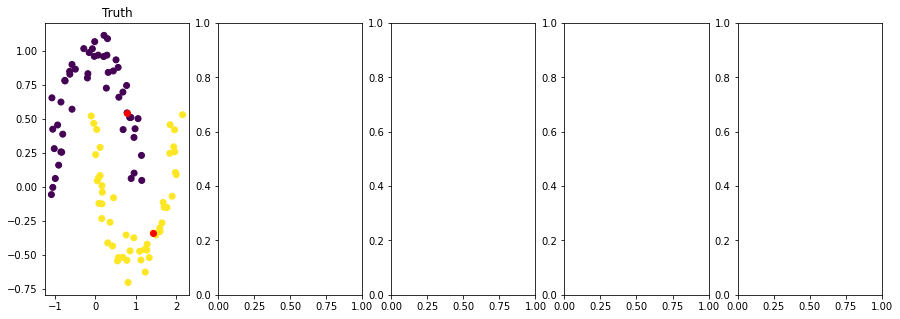

In [7]:
fig, ax = plt.subplots(1,5, figsize=(15,5))
n_labeled=2

X,y = make_moons(100, noise=0.1)

at_least_1_per = False
while not at_least_1_per:
    inds = np.random.choice(len(y), n_labeled, replace=False)
    if len(np.where(y[inds] == 1)[0]) > 0 and len(np.where(y[inds] == 1)[0]) < n_labeled:
        at_least_1_per=True
        

y_ = -1 * np.ones(100)
y_[inds] = y[inds]
        
ax[0].scatter(X[:, 0], X[:, 1], c=y)
ax[0].scatter(X[inds, 0], X[inds, 1], color='red')
ax[0].set_title('Truth')

n_neighbors = int(np.math.ceil(np.math.log(n_labeled)))
clf=AgglomerativeClassifier(affinity='euclidean', linkage='single', n_neighbors=n_neighbors, gem_p=1, classes=np.array([0,1]))
clf.fit(X, y_)
y_hat=clf.predict(X)
print((y_hat == y).mean())
ax[1].scatter(X[:, 0], X[:, 1], c=y_hat)
ax[1].set_title('AggClass')

clf=LinearSVC()
clf.fit(X[inds], y[inds])
y_hat=clf.predict(X)
print((y_hat == y).mean())
ax[2].scatter(X[:, 0], X[:, 1], c=y_hat)
ax[2].set_title('SVM (rbf)')

clf=RandomForestClassifier()
clf.fit(X[inds], y[inds])
y_hat=clf.predict(X)
print((y_hat == y).mean())
ax[3].scatter(X[:, 0], X[:, 1], c=y_hat)
ax[3].set_title('Forest')


for i, algo in enumerate(algos):
    ax[4].scatter(n_labeled_list, np.mean(accuracies, axis=-1)[i], label=algo)
    ax[4].errorbar(n_labeled_list, np.mean(accuracies, axis=-1)[i], yerr=np.std(accuracies, axis=-1)[i] / np.sqrt(n_mc))
    
ax[4].legend()
ax[4].set_xlabel('# labeled samples')
ax[4].set_title('Accuracy vs # labeled samples')

for ax_ in ax[:-1]:
    ax_.set_yticks([])
    ax_.set_xticks([])
    
ax[4].set_yticks([0.7,0.8,0.9,1])
ax[4].set_xticks(n_labeled_list)

plt.tight_layout()